In [ ]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import models, transforms
import torchvision.transforms as transforms
from PIL import Image
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [ ]:


class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        target_layer = dict([*self.model.named_modules()])[self.target_layer]
        target_layer.register_forward_hook(forward_hook)
        target_layer.register_backward_hook(backward_hook)

    def generate_cam(self, input_tensor, target_class):
        self.model.zero_grad()
        output = self.model(input_tensor)
        one_hot_output = torch.zeros_like(output)
        one_hot_output[0][target_class] = 1
        output.backward(gradient=one_hot_output)

        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        activations = self.activations[0]
        for i in range(len(pooled_gradients)):
            activations[i, :, :] *= pooled_gradients[i]

        heatmap = torch.mean(activations, dim=0).detach().cpu().numpy()
        heatmap = np.maximum(heatmap, 0)
        heatmap /= np.max(heatmap)

        return heatmap

    def visualize(self, input_image, heatmap, alpha=0.4):
        heatmap = cv2.resize(heatmap, (input_image.shape[1], input_image.shape[0]))
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        superimposed_img = heatmap * alpha + input_image
        plt.imshow(superimposed_img / 255)
        plt.axis('off')
        plt.show()




  0%|          | 0/1000 [00:00<?, ?it/s]

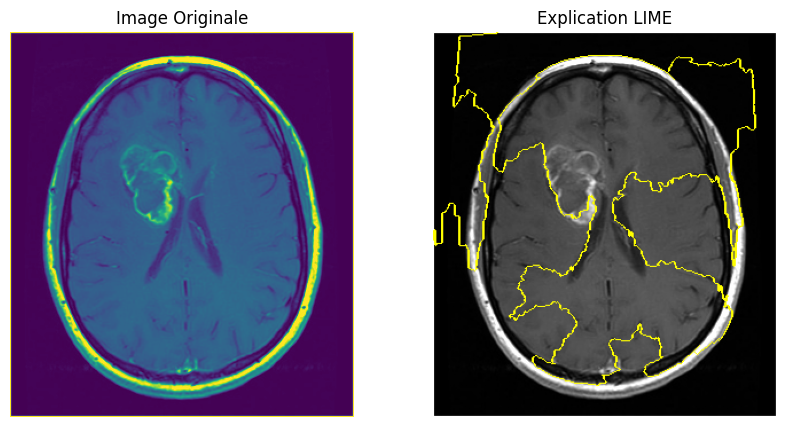

In [ ]:
# Fonction pour prédire avec le modèle
def predict_fn(images):
    # Convertir les images en tenseurs et appliquer les transformations
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Préparer les images pour la prédiction
    tensors = torch.stack([transform(Image.fromarray(image)) for image in images]).to(device)
    with torch.no_grad():
        outputs = resnet50_model(tensors)
        return torch.softmax(outputs, dim=1).cpu().numpy()

# Charger l'image d'entrée
input_image_path = '/content/drive/MyDrive/archive (7)/yes/Y101.jpg'
input_image = Image.open(input_image_path)
input_image_np = np.array(input_image)

# Créer l'instance de LIME
explainer = lime_image.LimeImageExplainer()

# Expliquer la prédiction pour l'image d'entrée
explanation = explainer.explain_instance(
    input_image_np,
    predict_fn,
    top_labels=5,
    hide_color=0,
    num_samples=1000
)

# Obtenir la meilleure explication pour la classe prédite
label_to_explain = explanation.top_labels[0]  # Classe la plus probable
temp, mask = explanation.get_image_and_mask( # Use explanation.get_image_and_mask instead of explainer.get_image_and_mask
    label_to_explain,
    positive_only=True,
    num_features=10,
    hide_rest=False
)

# Visualiser les résultats
plt.figure(figsize=(10, 5))

# Image originale
plt.subplot(1, 2, 1)
plt.imshow(input_image_np)
plt.title('Image Originale')
plt.axis('off')

# Image avec les contours des caractéristiques
plt.subplot(1, 2, 2)
plt.imshow(mark_boundaries(temp, mask))
plt.title('Explication LIME')
plt.axis('off')

plt.show()